# Análisis Discriminante

## 1. Preparación de ambiente de trabajo

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from imblearn.over_sampling import SMOTE

df = pd.read_csv('default_credit.csv',index_col=0)

plt.style.use('seaborn')                
plt.rcParams['figure.figsize'] = (8,6)  

In [2]:
df.head()

,default,student,balance,income
index,,,,
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 390.6+ KB


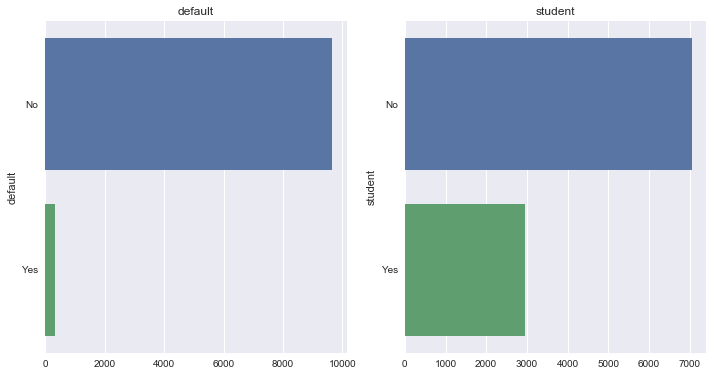

In [4]:
fig,_ = plt.subplots(figsize = (15,30))

for i, (colname,col) in enumerate (df.select_dtypes('O').iteritems()):
    plt.subplot(6,3,i+1)
    sns.countplot(y = df[colname],)
    plt.title(colname)
    plt.xlabel("")
    plt.tight_layout()

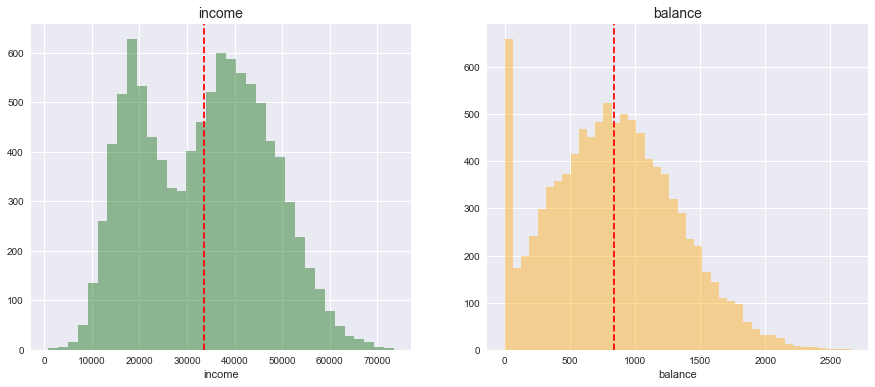

In [5]:
fig,ax = plt.subplots(1,2,figsize = (15,6))
ax[0].set_title('income',size=14)
ax[1].set_title('balance',size=14)


sns.distplot(df.income,ax=ax[0],color='darkgreen',kde=False)
sns.distplot(df.balance,ax=ax[1],color='orange',kde=False)


mean_balance=df['balance'].mean()
mean_income=df['income'].mean()

ax[0].axvline(mean_income, color='r', linestyle='--')
ax[1].axvline(mean_balance, color='r', linestyle='--')

sns.despine();

En los gráficos que poseen las variables discretas, existe un evidente desbalance de clases, lo cual deberá ser considerado o compensado, al momento de generar los modelos.

En cuanto a la distribución del ingreso, esta no posee una distribución normal. Por su parte el balance, si tiene una distribución tipo Gaussiana, sin embargo tiene una gran cantidad de valores cercanos a 0.

## 2. Modelo base

In [6]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns 

    def fit(self,X,y=None):
        return self 

    def transform(self,X):
  
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [7]:
df = MultiColumnLabelEncoder(columns = ['default','student']).fit_transform(df)

In [8]:
df

,default,student,balance,income
index,,,,
1,0,0,729.526495,44361.625074
2,0,1,817.180407,12106.134700
3,0,0,1073.549164,31767.138947
4,0,0,529.250605,35704.493935
5,0,0,785.655883,38463.495879
...,...,...,...,...
9996,0,0,711.555020,52992.378914
9997,0,0,757.962918,19660.721768
9998,0,0,845.411989,58636.156984


In [9]:
y_vec = df['default']
X_mat = df.drop(['default'],axis=1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_mat,
                                                    y_vec,
                                                    test_size=0.33,
                                                    random_state=123)

In [11]:
X_train = StandardScaler().fit_transform(X_train)

X_test = StandardScaler().fit_transform(X_test)

In [12]:
lda_classifier = LinearDiscriminantAnalysis()
lda_classifier.fit(X_train, y_train)
y_hat = lda_classifier.predict(X_test)

In [13]:
def plot_class_report(y_test, y_hat, classes_labels):

    plt.figure(figsize=(15, 10))
    tmp_report = classification_report(y_test, y_hat, output_dict=True)
    targets = list(classes_labels)
    targets.append('average')
    tmp_report = pd.DataFrame(tmp_report)\
                    .drop(columns=['weighted avg', 'macro avg'])
    tmp_report.columns = targets
    tmp_report = tmp_report.drop(labels='support')
    tmp_report = tmp_report.drop(columns='average')
    tmp_report = tmp_report.T

    for index, (colname, serie) in enumerate(tmp_report.iteritems()):
        plt.subplot(3, 1, index + 1)
        serie.plot(kind = 'barh')
        plt.title(f"Métrica: {colname}")
        plt.tight_layout()

In [14]:
target_label = ['0','1']

In [15]:
def plot_class_report(y_test, y_hat, classes_labels):

    plt.figure(figsize=(15, 10))
    tmp_report = classification_report(y_test, y_hat, output_dict=True)
    targets = list(classes_labels)
    targets.append('average')
    tmp_report = pd.DataFrame(tmp_report)\
                    .drop(columns=['weighted avg', 'macro avg'])
    tmp_report.columns = targets
    tmp_report = tmp_report.drop(labels='support')
    tmp_report = tmp_report.drop(columns='average')
    tmp_report = tmp_report.T

    for index, (colname, serie) in enumerate(tmp_report.iteritems()):
        plt.subplot(3, 1, index + 1)
        serie.plot(kind = 'barh')
        plt.title(f"Métrica: {colname}")
        plt.tight_layout()

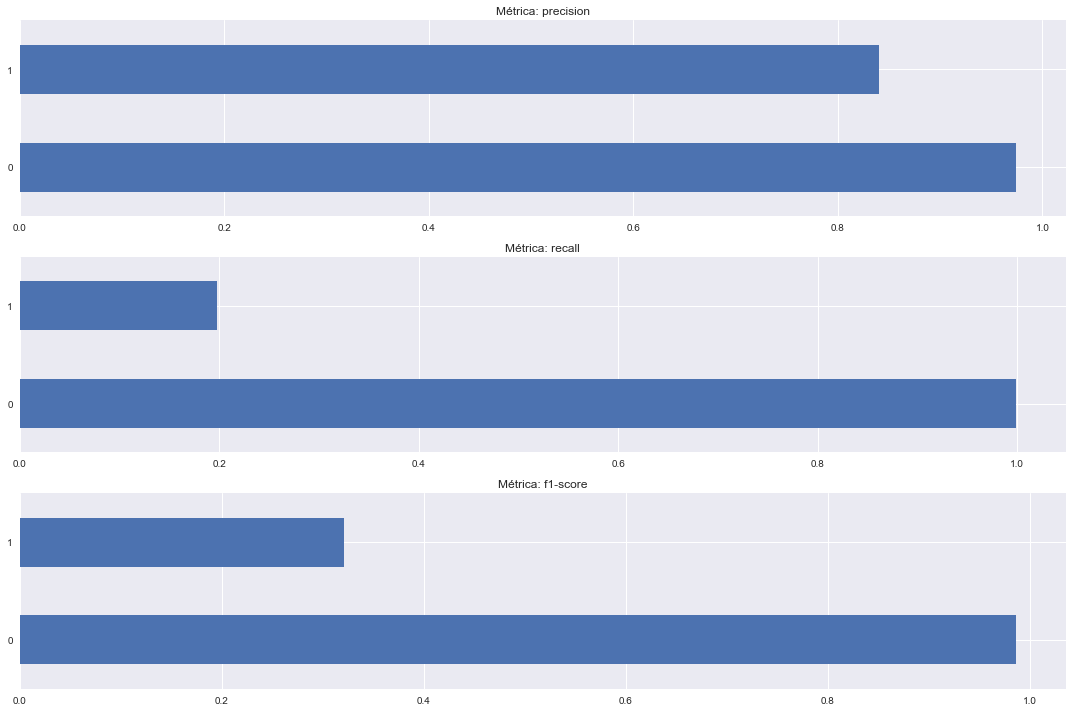

In [16]:
plot_class_report(y_test, y_hat, target_label)

Lo más que más llama la atención de los tres gráficos con el modelo LDA, es que el recall, que da cuenta del número de personas con deudas que esta registrando el modelo, es bajo. Solo está captando aproximadamente un 20% de todos los valores que realemente serían clasificados como deuda, los otros clientes, no los estaría captando, es decir un 80% de los clientes con deuda, pasarían por alto.

El F1 da cuenta de la misma situación que en el recall, pero el desempeño es alto en cuanto a los valores de 0.

## 3. Refactorización 1 - información a priori

In [17]:
lda_50_classifier = LinearDiscriminantAnalysis(priors=[.5,.5])
lda_50_classifier.fit(X_train, y_train)
y_50_hat = lda_50_classifier.predict(X_test)

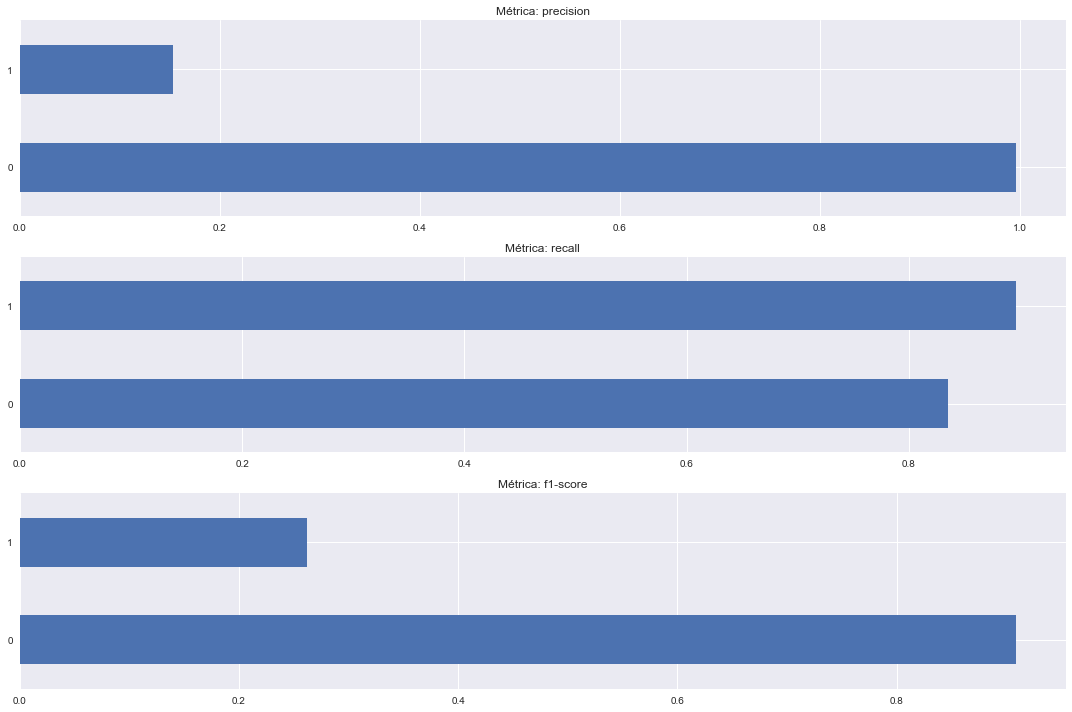

In [18]:
plot_class_report(y_test, y_50_hat, target_label)

En este caso, el modelo LDA con un 50% de las muestra con deuda, se mejora el recall para la variable a detectar (morosidad), sin embargo disminuye su desempeño en la métrica de presición. Esto quiere decir que de todos los valores sensados, entre un 15% a 20%, efectivamente eran clientes con deudas (True Positive).

Finalmente, al comparar el F1 con el modelo anterior, el desempeño es levemente mejor para detectar posibles clientes endudados, pero baja levemente respecto a los clientes sin deuda.


In [19]:
lda_60_classifier = LinearDiscriminantAnalysis(priors=[.6,.4])
lda_60_classifier.fit(X_train, y_train)
y_60_hat = lda_60_classifier.predict(X_test)

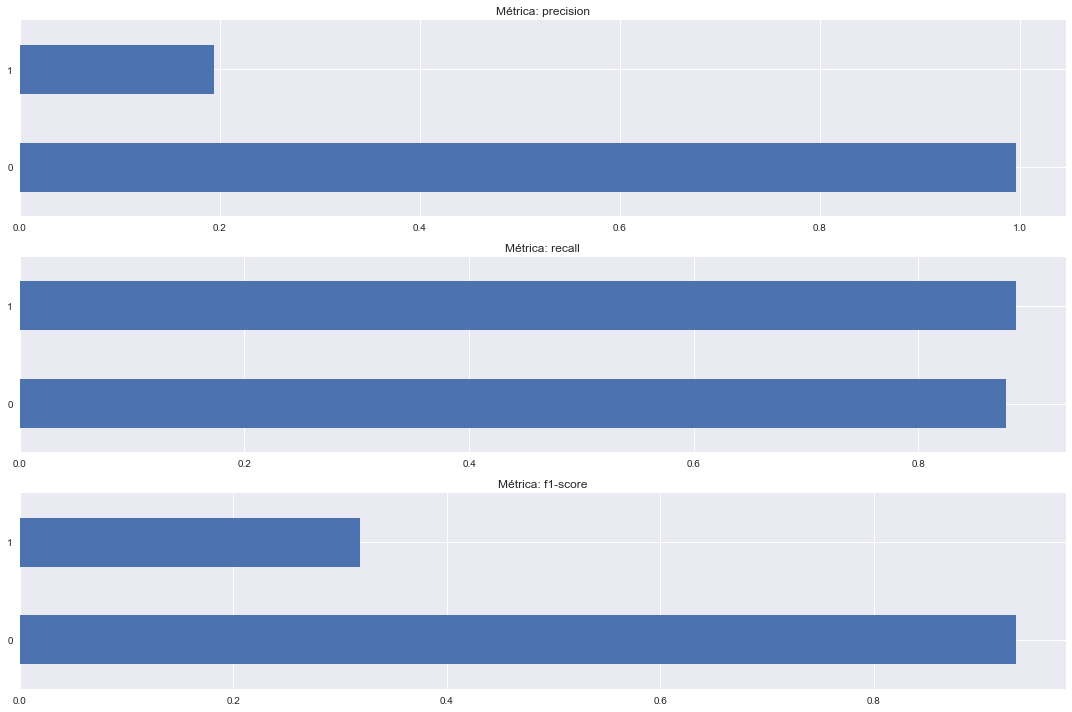

In [20]:
plot_class_report(y_test, y_60_hat, target_label)

El modelo LDA con un 60% de los datos, tiene el mejor desemepeño de F1 de todos los modelos. El recall sube considerablemente, por lo tanto hay pocas omisiones de los valores verdaderos (recall), pero también detecta más valores que son de otras clases (presición). 

A pesar de la mejora, en general no es un modelo óptimo o ideal.

## 4. Refactorización 2 - oversampling

In [21]:
oversampler = SMOTE(random_state=138,sampling_strategy='minority')

X_train_oversamp, y_train_oversamp = oversampler.fit_sample(X_train, y_train)

In [22]:
lda_classifier = LinearDiscriminantAnalysis()
lda_classifier.fit(X_train_oversamp, y_train_oversamp)
y_hat_lda_oversamp = lda_classifier.predict(X_test)

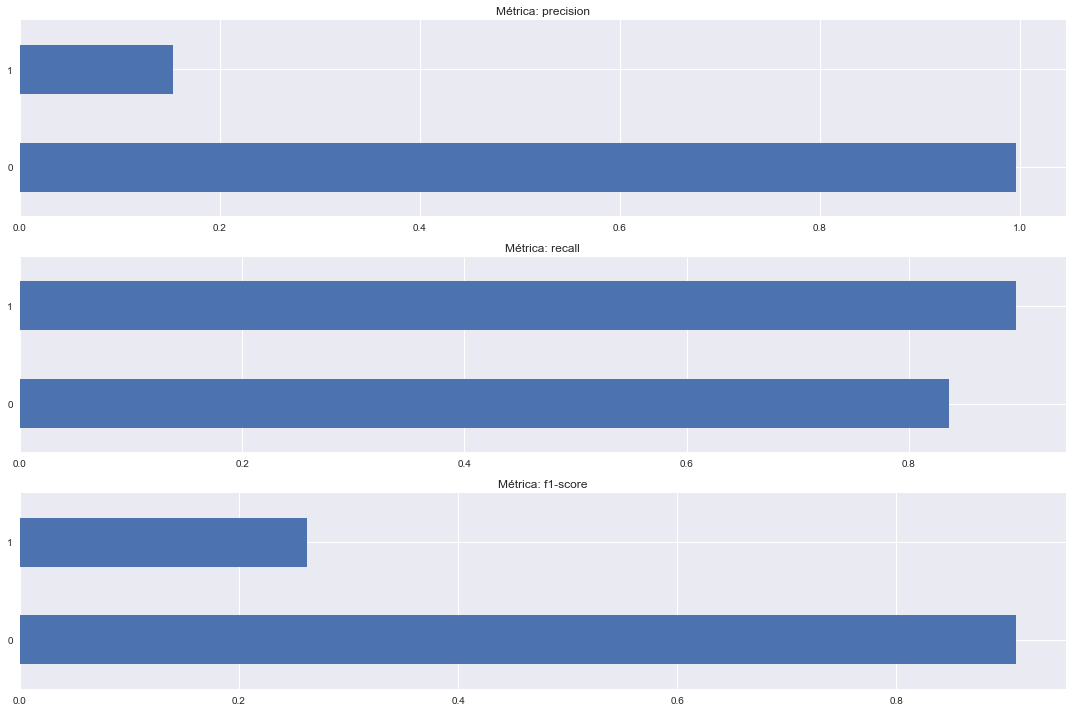

In [23]:
plot_class_report(y_test, y_hat_lda_oversamp, target_label)

## 5. Refactorización 3 - QDA

In [24]:
qda_classifier = QuadraticDiscriminantAnalysis()
qda_classifier.fit(X_train_oversamp, y_train_oversamp)
y_hat_qda_oversamp = qda_classifier.predict(X_test)

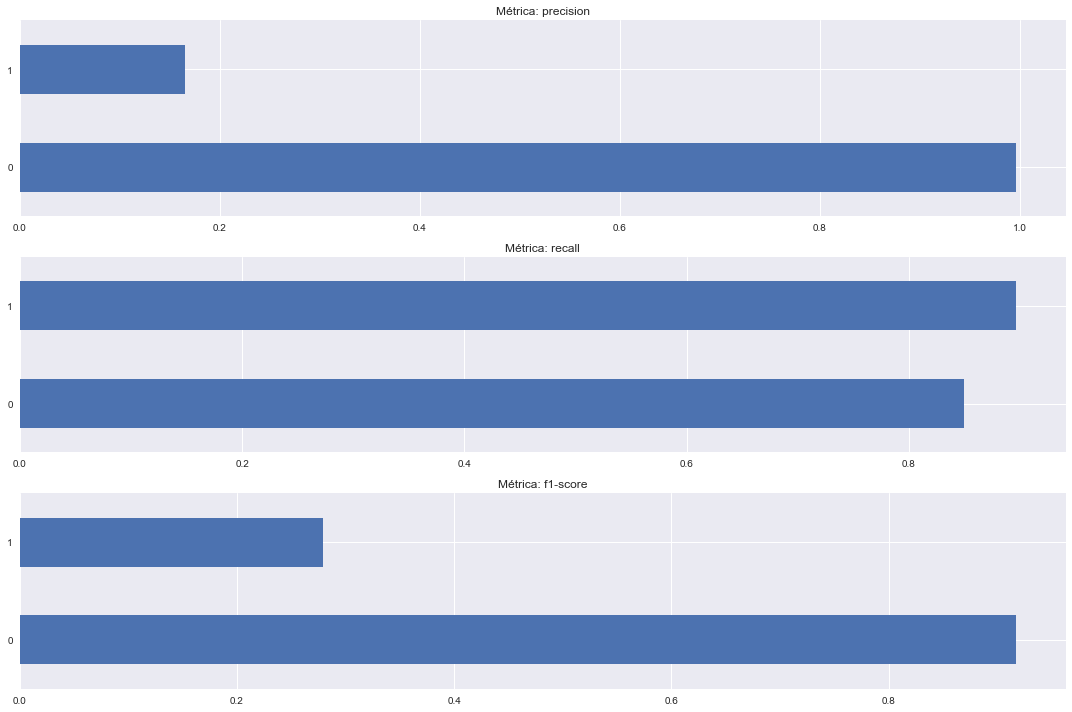

In [25]:
plot_class_report(y_test, y_hat_qda_oversamp, target_label)

En cuanto a los modelos LDA y QDA, con Oversampling (Problemas 4 y 5), no se aprecian diferencias importantes en sus desempeños.

Si evaluamos el desempeño general de los modelos, con la media armónica de entre Recall y Precision, el modelo que 
mejor se ajusta al problema, sería el que está desarrollado con LDA y con un 60% de los clientes morosos.

De todas maneras habría que evaluar equipara aún más la muestra del los clientes morosos, sobre el 60% de la muestra, para conocer si hay otros modelos con mejores desempeños para el puntaje F1 de la variable objetivo.